### Grover Search

In [51]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import math

In [52]:
# --- 1. 例として：|101> をヒットさせる 3量子ビット用オラクル -------------------
def build_oracle(n: int, target_state: str = "101") -> QuantumCircuit:
    """
    n            : 量子ビット数
    target_state : 文字列 '0'/'1' の列で指定（長さ n）
    指定ビット列と一致する場合に位相を π 反転する Z ゲート系列
    """
    if len(target_state) != n:
        raise ValueError("length of target_state must equal n")

    oracle = QuantumCircuit(n)

    # 0 の箇所は X を当てて |111…> に写像して制御多重 Z（MCZ）をかける
    for i, bit in enumerate(reversed(target_state)):
        if bit == '0':
            oracle.x(i)

    oracle.h(n-1)           # 最上位をターゲットにした MCZ を CCX 等で代用
    oracle.mcx(list(range(n-1)), n-1)
    oracle.h(n-1)

    # 0 を写像するために入れた X を戻す
    for i, bit in enumerate(reversed(target_state)):
        if bit == '0':
            oracle.x(i)

    oracle.name = f"Oracle(|{target_state}⟩)"
    return oracle

In [53]:
def diffuser(n: int) -> QuantumCircuit:
    diff = QuantumCircuit(n)

    diff.h(range(n))
    diff.x(range(n))

    diff.h(n-1)
    diff.mcx(list(range(n-1)), n-1)
    diff.h(n-1)

    diff.x(range(n))
    diff.h(range(n))

    diff.name = "Diffuser"
    return diff

In [54]:
def grover_circuit(n: int, oracle_gate: QuantumCircuit, shots: int = 1024) -> QuantumCircuit:
    qc = QuantumCircuit(n, n)

    # ① 初期化：|+⟩^⊗n
    qc.h(range(n))

    # ② 反復回数 k ≈ π/4 * √N （ターゲット1個想定）
    k = round(math.pi / 4 * math.sqrt(2**n))
    for _ in range(k):
        qc.append(oracle_gate.to_gate(), range(n))
        qc.append(diffuser(n).to_gate(), range(n))

    # ③ 測定
    qc.measure(range(n), range(n))
    return qc

In [ ]:
def run_grover(n: int, target_state: str, shots: int = 1024):
    oracle  = build_oracle(n, target_state)
    qc      = grover_circuit(n, oracle, shots)

    display(qc.draw("mpl", style="iqp"))

    sim     = AerSimulator()
    tqc     = transpile(qc, sim)
    result  = sim.run(tqc, shots=shots).result()
    counts  = result.get_counts()

    guess = max(counts, key=counts.get)
    print(f"→ measured: |{guess}⟩  (expected |{target_state}⟩)  success_ratio={counts[guess]/shots:.2%}")


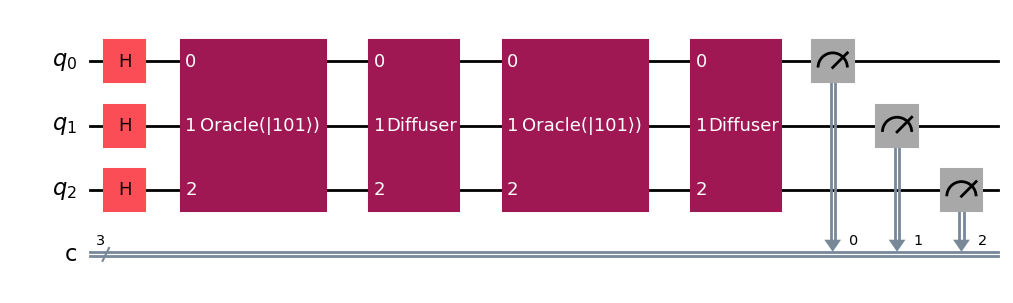

→ measured: |101⟩  (expected |101⟩)  success_ratio=94.24%


In [56]:
n_qubits = 3
run_grover(n_qubits, target_state="101")

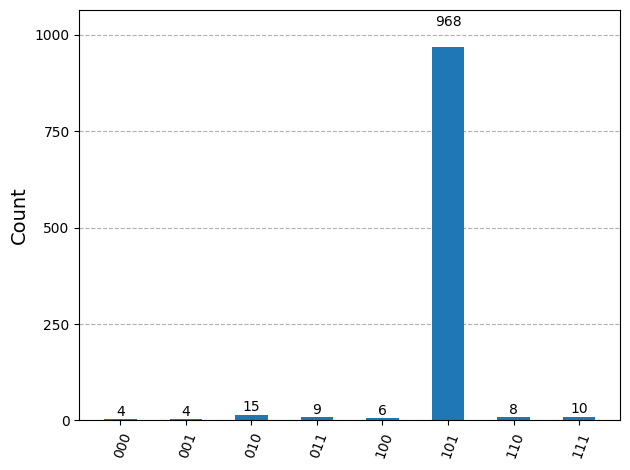

In [57]:
plot_histogram(counts)

In [ ]:
def show_oracle(n: int, tgt: str = "101", *, output: str = "text") -> QuantumCircuit:
    qc = build_oracle(n, tgt)

    if output == "text":
        print(f"\n### Oracle for |{tgt}⟩  (n={n})\n")
        print(qc.draw(output="text"))
    elif output in ("mpl", "latex"):
        circuit_drawer(qc, output=output)
    else:
        raise ValueError("output must be 'text', 'mpl', or 'latex'")

    return qc


if __name__ == "__main__":
    show_oracle(3, "101", output="text")



### Oracle for |101⟩  (n=3)

                    
q_0: ───────■───────
     ┌───┐  │  ┌───┐
q_1: ┤ X ├──■──┤ X ├
     ├───┤┌─┴─┐├───┤
q_2: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘


In [ ]:
def show_diffuser(n: int, *, output: str = "text") -> QuantumCircuit:
    qc = diffuser(n)

    if output == "text":
        print(f"\n### Diffuser  (n={n})\n")
        print(qc.draw(output="text"))
    elif output in ("mpl", "latex"):
        circuit_drawer(qc, output=output)
    else:
        raise ValueError("output must be 'text', 'mpl', or 'latex'")

    return qc

if __name__ == "__main__":
    show_diffuser(3, output="text")


### Diffuser  (n=3)

     ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘
